In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from models.FNO import FNO2D
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import scipy
import scipy.sparse as sp


In [7]:
from neuralop import LpLoss
M = 1
model_list = [FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu) for i in range(M)]
save_dir = "./checkpoints_circletest"
optimizer_list = [torch.optim.Adam(model_list[i].parameters(), lr=1e-3,weight_decay=1e-4) for i in range(M)]

scheduler_list = [torch.optim.lr_scheduler.StepLR(optimizer_list[i],step_size=100,gamma = 0.5) for i in range(M)]

train_loss = LpLoss(d = 2, p = 2, reductions = "sum")

#load the model if needed
a = 1
if a == 1:
    
    for i in range(0,M): 
        state_dict = torch.load(f"{save_dir}/model_state_{i+1}.pt",map_location=torch.device('cpu'))
        model_list[i].load_state_dict(state_dict)




In [8]:
from neuralop.datasets.output_encoder import UnitGaussianNormalizer

x_train = torch.load('./dirichlet_100000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('./dirichlet_100000_32_y.pt').clone().type(torch.FloatTensor)
y_train = y_train.unsqueeze(1)
print(x_train.shape, y_train.shape)

reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(dim = reduce_dims)
input_encoder.fit(x_train)
# print(input_encoder.mean, input_encoder.std)

reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim = reduce_dims)
output_encoder.fit(y_train)


x_train = input_encoder.transform(x_train)
y_train = output_encoder.transform(y_train)


torch.Size([10000, 1, 32, 32]) torch.Size([10000, 1, 32, 32])


In [9]:
from data_transforms.positional_embedding_polar import PositionalEmbedding2D_polar

grid_boundaries = [[0,1],[0,2*np.pi]]
pos_enc = PositionalEmbedding2D_polar(grid_boundaries)
x_train =pos_enc(x_train)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )
train_loader_list = [train_loader for i in range(M)]


In [10]:
#test set
x_test = torch.load('./dirichlet_100_32_x.pt').clone()
y_test = torch.load('./dirichlet_100_32_y.pt').clone()

y_test = y_test.unsqueeze(1)



x_test = input_encoder.transform(x_test)

y_test = output_encoder.transform(y_test)

x_test = pos_enc(x_test)



test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )


test_loader_list = [test_loader for i in range(M)]

eval_loss = train_loss

In [6]:
from callbacks.checkpointcallback_ensemble import CheckpointCallbackEnsemble
from callbacks.loggercallback_ensemble import LoggerCallbackEnsemble
from callbacks.loggercallback import LoggerCallback



ckpt = CheckpointCallbackEnsemble(save_dir=save_dir,
                                       save_freq=10)
logger = LoggerCallbackEnsemble(save_dir=save_dir, n_models = M)

from training.trainer_ensemble import Trainer_Ensemble
trainer = Trainer_Ensemble(model_list=model_list, n_epochs=301,
                  device=device,
                  callbacks=[ckpt,logger],
                  log_test_interval=1,
                  verbose=True)

In [7]:

trainer.train(train_loader_list=train_loader_list,
              test_loaders_list=test_loader_list,
              optimizer_list=optimizer_list,
              scheduler_list=scheduler_list, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Model 0 - Train Epoch: 0 	Loss: 50.954329
Test set: Average loss: 2.2849

Model saved at epoch 0.
Model 0 - Train Epoch: 1 	Loss: 16.536375
Test set: Average loss: 1.3631

Model 0 - Train Epoch: 2 	Loss: 10.939946
Test set: Average loss: 1.0724

Model 0 - Train Epoch: 3 	Loss: 8.106438
Test set: Average loss: 0.7791

Model 0 - Train Epoch: 4 	Loss: 7.148354
Test set: Average loss: 0.7889

Model 0 - Train Epoch: 5 	Loss: 6.338951
Test set: Average loss: 0.6126

Model 0 - Train Epoch: 6 	Loss: 5.833083
Test set: Average loss: 0.5670

Model 0 - Train Epoch: 7 	Loss: 5.323350
Test set: Average loss: 0.5228

Model 0 - Train Epoch: 8 	Loss: 5.110168
Test set: Average loss: 0.5258

Model 0 - Train Epoch: 9 	Loss: 5.290056
Test set: Average loss: 0.6043

Model 0 - Train Epoch: 10 	Loss: 4.777506
Test set: Average loss: 0.5078

Model saved at epoch 10.
Model 0 - Train Epoch: 11 	Loss: 4.395459
Test set: Average loss: 0.5186

Model 0 - Train Epoch: 12 	Loss: 5.240083
Test set: Average loss: 0.40

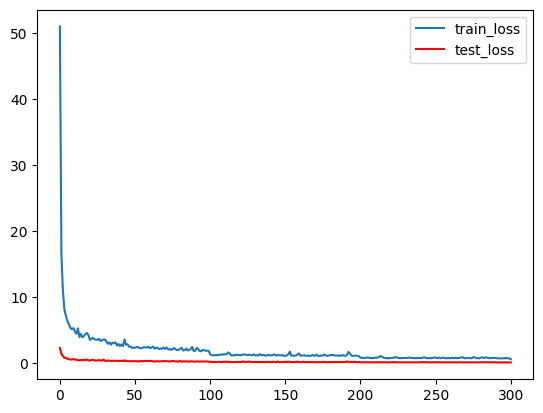

In [11]:
import pandas as pd
losses = [pd.read_csv(f"{save_dir}/loss_{i+1}.csv") for i in range(M)]



for i in range(M):
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Train Loss"],"-",label="train_loss")
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Test Loss"],"-r",label="test_loss")
    plt.legend()
    plt.show()

In [87]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def solve_poisson_unit_disc(f, Nr, Ntheta):
    # Create grid
    r = np.linspace(0, 1, Nr + 1)
    theta = np.linspace(0, 2 * np.pi, Ntheta, endpoint=False)
    dr = r[1] - r[0]
    dtheta = theta[1] - theta[0]
    
    # Initialize the solution vector and the right-hand side
    U = np.zeros((Nr + 1, Ntheta))
    F = np.zeros((Nr + 1, Ntheta))
    
    # Populate F with values of the function f on the grid
    for i in range(Nr + 1):
        for j in range(Ntheta):
            F[i, j] = -f(r[i], theta[j])
    
    # Create sparse matrix for the linear system
    A = lil_matrix(((Nr + 1) * Ntheta, (Nr + 1) * Ntheta))
    b = np.zeros((Nr + 1) * Ntheta)
    
    # Fill the matrix and right-hand side
    for i in range(1, Nr):
        for j in range(Ntheta):
            k = i * Ntheta + j
            
            A[k, k] = -2 / dr**2 - 2 / (r[i]**2 * dtheta**2)
            A[k, k - 1 if j > 0 else k + Ntheta - 1] = 1 / (r[i]**2 * dtheta**2)
            A[k, k + 1 if j < Ntheta - 1 else k - Ntheta + 1] = 1 / (r[i]**2 * dtheta**2)
            A[k, k - Ntheta] = 1 / dr**2 - 1 / (2 * r[i] * dr)
            A[k, k + Ntheta] = 1 / dr**2 + 1 / (2 * r[i] * dr)
            
            b[k] = F[i, j]
    
    # Apply boundary conditions (u = 0 on the boundary)
    for j in range(Ntheta):
        k = j
        A[k, k] = 1
        b[k] = 0
        k = Nr * Ntheta + j
        A[k, k] = 1
        b[k] = 0
    
    # Solve the linear system
    A = A.tocsr()
    U_flat = spsolve(A, b)
    
    # Reshape the solution to 2D array
    U = U_flat.reshape((Nr + 1, Ntheta))
    
    return r, theta, U

/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/1057260003.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X, Y, U, shading='auto')


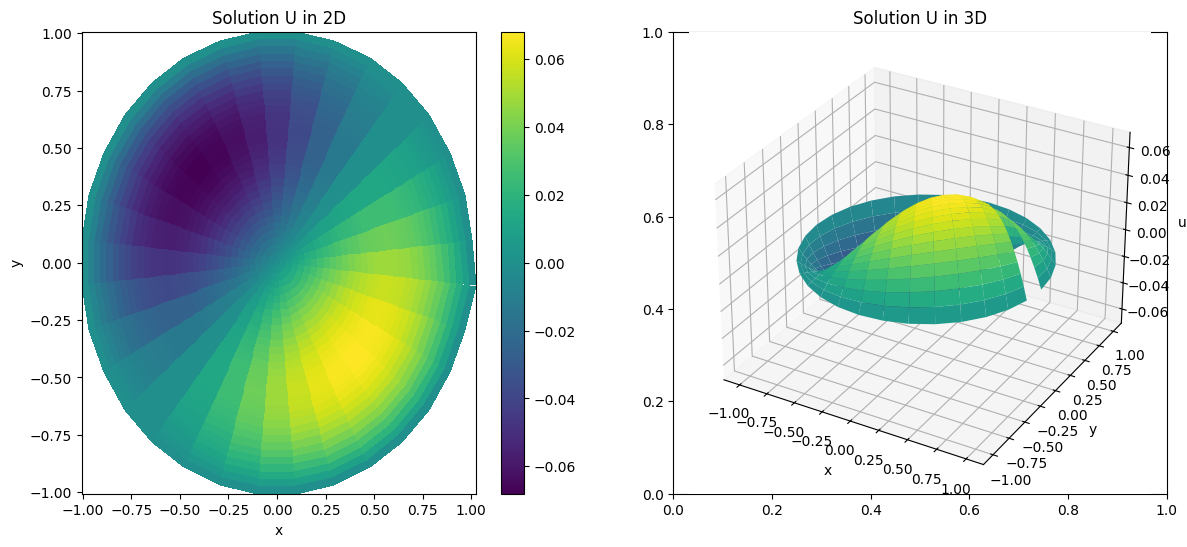

In [97]:
# Example usage
def example_f(r, theta):
    #return np.sin(np.pi * r) * np.cos(theta)
    #return r*np.sin(theta) - r * np.cos(theta)
    return r*np.cos(theta) - r * np.sin(theta)


Nr = 31
Ntheta = 32
r, theta, U = solve_poisson_unit_disc(example_f,Nr,Ntheta)

# Convert the polar grid to Cartesian coordinates for visualization
R, Theta = np.meshgrid(r, theta, indexing='ij')
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 2D plot
fig0 = axs[0].pcolormesh(X, Y, U, shading='auto')
fig.colorbar(fig0, ax=axs[0])
axs[0].set_title("Solution U in 2D")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# 3D plot
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_title("Solution U in 3D")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u")

plt.show()




In [98]:
N = 32
r_range = np.linspace(1e-8,1,N)
theta_range = np.linspace(0,2*np.pi, N)
R,Theta = np.meshgrid(r_range, theta_range)

X = R * np.cos(Theta)
Y = R * np.sin(Theta)

sample = torch.tensor(example_f(R,Theta)).unsqueeze(0).unsqueeze(0)



torch.Size([1, 1, 32, 32])
tensor([[[[-1.0611e-05,  4.0619e-03,  8.2089e-03,  ...,  1.5211e-02,
            8.0111e-03,  1.2501e-04],
          [-3.3379e-05,  3.1460e-03,  6.3542e-03,  ...,  1.1773e-02,
            6.1571e-03,  7.0020e-05],
          [-7.8628e-05,  2.1174e-03,  4.2402e-03,  ...,  7.9767e-03,
            4.1384e-03,  2.4266e-05],
          ...,
          [ 1.6280e-05,  5.4389e-03,  1.0750e-02,  ...,  1.9802e-02,
            1.0494e-02,  1.4268e-04],
          [-7.7088e-06,  4.9251e-03,  9.6528e-03,  ...,  1.7794e-02,
            9.4567e-03,  1.8710e-04],
          [ 7.6599e-06,  4.1449e-03,  8.1687e-03,  ...,  1.5086e-02,
            7.9273e-03,  1.9261e-04]]]])


/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/2462906243.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/2462906243.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,sample[0,0,:,:].cpu().detach().numpy())
/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/2462906243.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decrea

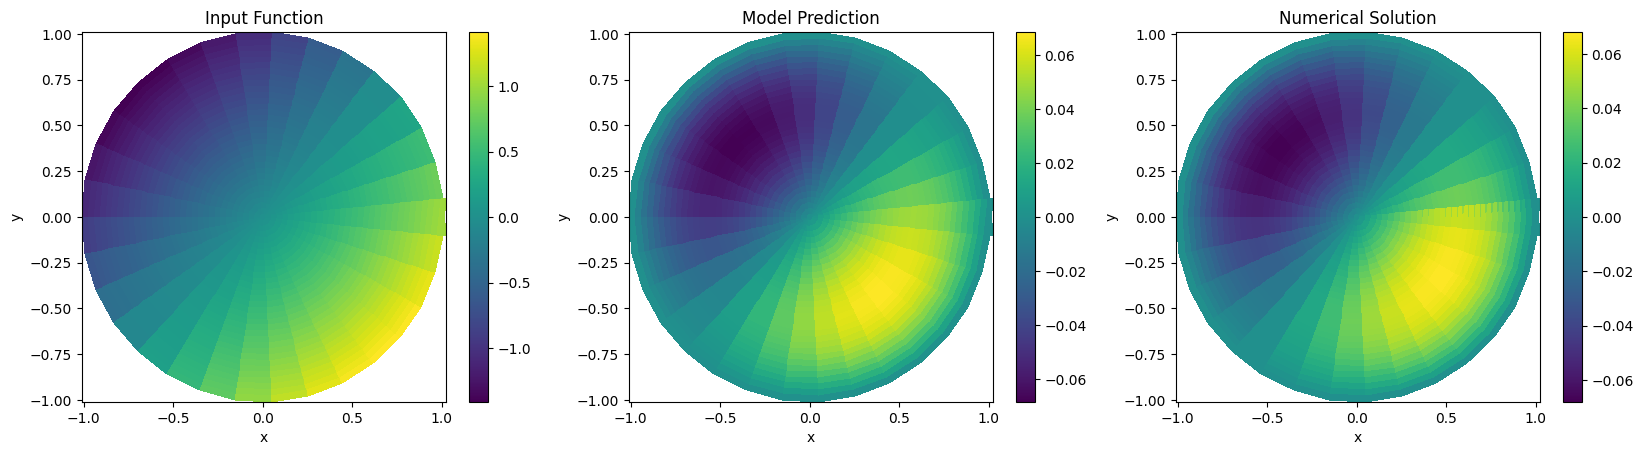

In [99]:
#prediction time for f


for i in range(M): model_list[i].eval().to(device) 



#sample = torch.load("../finput.pt").clone().type(torch.FloatTensor)



sample_scaled = input_encoder.transform(sample.type(torch.FloatTensor))
print(sample_scaled.shape)



#preprocessing

sample_scaled = pos_enc(sample_scaled).to(device)

out = [model_list[i](sample_scaled).to(device) for i in range(M)]
#return to original scale
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
print(mu_unseen)
var_unseen = torch.mean(torch.stack([torch.square(out[i] - mu_unseen) for i in range(M)], dim = 0),dim=0)




#mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)


U = torch.tensor(U).clone().to(device)
#print(U.shape)
#U_scaled = output_encoder.transform(U.unsqueeze(0).unsqueeze(0).cpu()).to(device)

#print(train_loss(mu_unseen,(U)))



# Plotting
fig, axs = plt.subplots(nrows = 1, ncols =3,gridspec_kw={'width_ratios': [1, 1,1]})
fig.set_figwidth(20)


fig0 = axs[0].pcolormesh(X,Y,sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,mu_unseen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

R,Theta = np.meshgrid(r_range, theta_range, indexing = "ij")

X = R * np.cos(Theta)
Y = R * np.sin(Theta)

#actual
fig2 = axs[2].pcolormesh(X,Y,U.cpu().detach().numpy())

fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/1398034262.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/1398034262.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,input_encoder.inverse_transform(test_loader.dataset[i][0].unsqueeze(0)).to(device)[0,0,:,:].cpu().detach().numpy())
/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/1398034262.py:40: UserWarning: The input coordinates to pcolormesh are

tensor([[[[ 2.3961e-04,  2.3306e-02,  1.7291e-02,  ...,  9.1708e-03,
           -7.7878e-03,  2.0741e-04],
          [-4.3852e-04,  2.3176e-02,  1.8319e-02,  ...,  3.2244e-02,
            1.7529e-02, -7.6678e-04],
          [-2.5055e-04,  2.3423e-02,  2.3437e-02,  ...,  3.2488e-02,
            8.8730e-03, -6.7381e-04],
          ...,
          [-2.0243e-04,  2.2245e-02,  2.4881e-02,  ..., -5.8200e-02,
           -3.7575e-02, -2.4875e-04],
          [-5.9654e-05,  2.2370e-02,  1.9261e-02,  ..., -2.0040e-02,
           -4.7918e-04, -3.4429e-05],
          [-4.2742e-04,  2.2616e-02,  1.6652e-02,  ...,  8.1390e-03,
           -1.0035e-02,  1.1953e-04]]]])
tensor(0.0116)


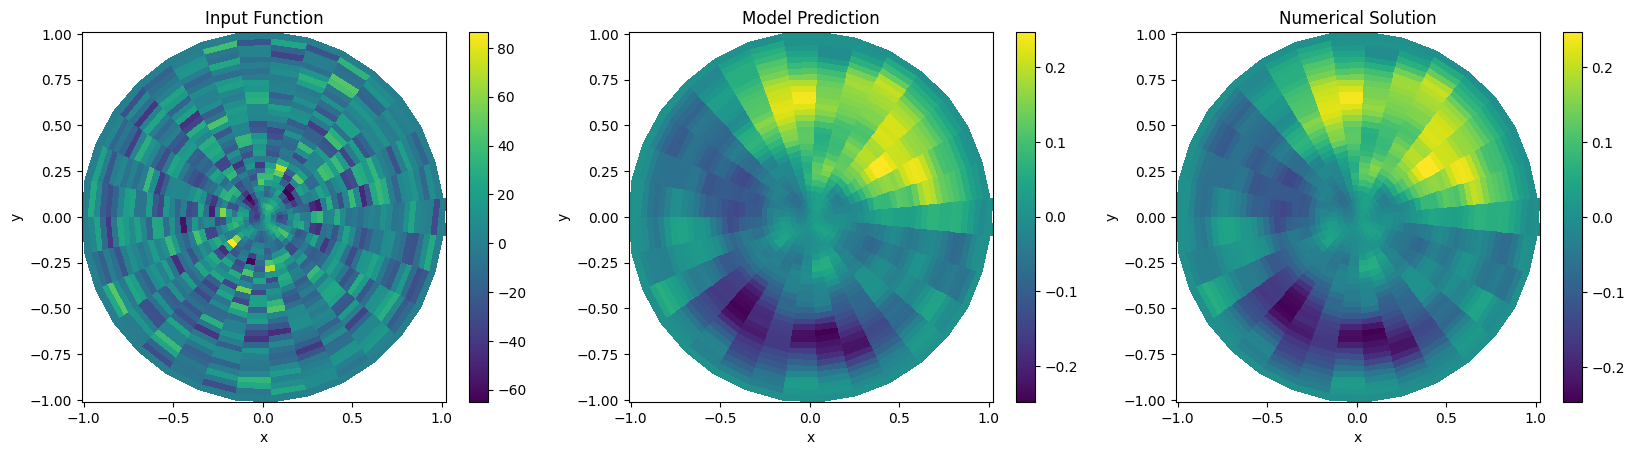

In [17]:
#prediction time
i = np.random.randint(0,100)
j = np.random.randint(0,100)
sample = test_loader.dataset[i][0].unsqueeze(0).to(device)
solution_scaled = test_loader.dataset[i][1].unsqueeze(0)
solution = output_encoder.inverse_transform(solution_scaled).to(device)
#solution = solve_poisson_on_unit_disc(sample.cpu().detach().numpy()[0,0,:,:],grid_size,grid_size)

#preprocessing
out = [model_list[i](sample) for i in range(M)]
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

#var on model scale
mu_seen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
print(mu_seen)
var_seen = (torch.mean(torch.stack([torch.square(out[i] - mu_seen) for i in range(M)],dim=0), dim = 0))


#print(train_loss(mu_seen,output_encoder.inverse_transform(test_loader.dataset[i][1]).to(device)))
print(train_loss(mu_seen,solution))

#print(NLL_2(*out,train_loader.dataset[i][1].to(device)))




# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3,gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(20)

#fig0 = axs[0].pcolormesh(X,Y,test_loader.dataset[i][0].unsqueeze(0).to(device)[0,0,:,:].cpu().detach().numpy())
fig0 = axs[0].pcolormesh(X,Y,input_encoder.inverse_transform(test_loader.dataset[i][0].unsqueeze(0)).to(device)[0,0,:,:].cpu().detach().numpy())

fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,mu_seen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


#actual
fig2 = axs[2].pcolormesh(X,Y,solution[0,0,:,:])
fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


torch.Size([1, 3, 100, 100])
tensor(11.9843)


/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/160189403.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/160189403.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,input[0,0,:,:])
/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/160189403.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to inco

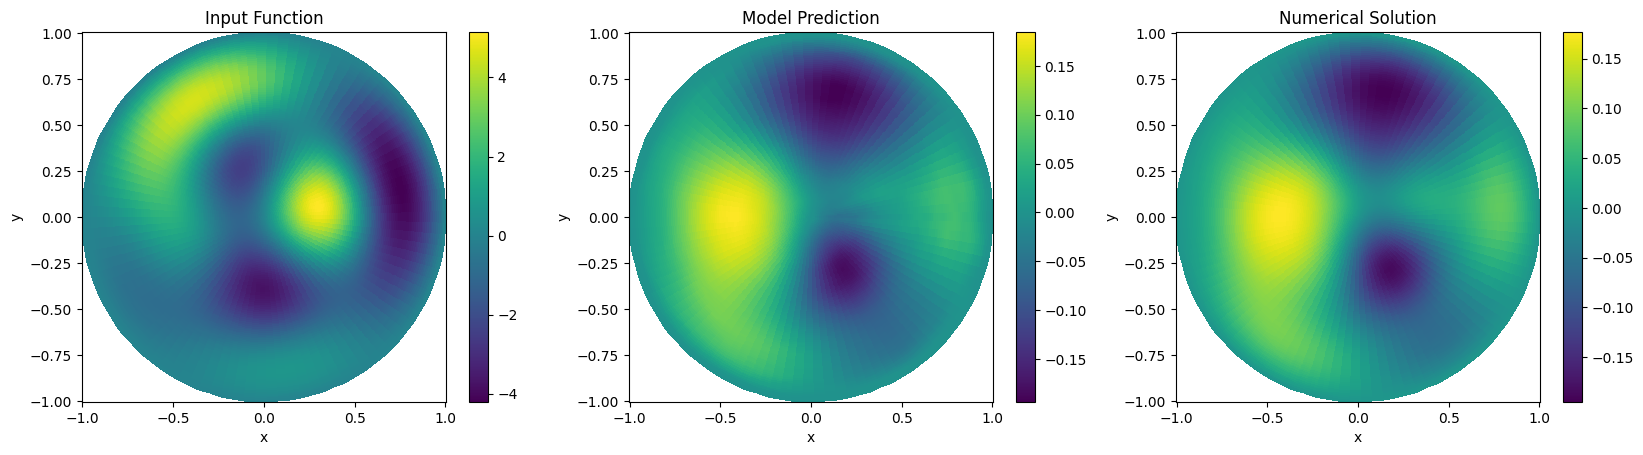

In [29]:
grid_size = 100
r = np.linspace(1e-8,1,grid_size)
theta = np.linspace(1e-8,2*np.pi,grid_size)
R, Theta = np.meshgrid(r,theta)

X,Y = R*np.cos(Theta), R*np.sin(Theta)



#prediction time
i = np.random.randint(0,10)


x_val = torch.load('./dirichlet_10_100_x.pt').clone()
input  = x_val.clone()
y_val = torch.load('./dirichlet_10_100_y.pt').clone()
y_val = y_val.unsqueeze(1)

x_val = input_encoder.transform(x_val)
sample = pos_enc(x_val)
sample = sample[i,:,:,:].unsqueeze(0)
solution = y_val[i,:,:,:].unsqueeze(0)
print(sample.shape)


#preprocessing
out = [model_list[i](sample) for i in range(M)]
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

#var on model scale
mu_seen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
var_seen = (torch.mean(torch.stack([torch.square(out[i] - mu_seen) for i in range(M)],dim=0), dim = 0))


#print(train_loss(mu_seen,output_encoder.inverse_transform(test_loader.dataset[i][1]).to(device)))
print(train_loss(mu_seen,y_val))

#print(NLL_2(*out,train_loader.dataset[i][1].to(device)))




# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3,gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(20)

#fig0 = axs[0].pcolormesh(X,Y,test_loader.dataset[i][0].unsqueeze(0).to(device)[0,0,:,:].cpu().detach().numpy())
fig0 = axs[0].pcolormesh(X,Y,input[0,0,:,:])
fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,mu_seen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


#actual
fig2 = axs[2].pcolormesh(X,Y,solution[0,0,:,:])
fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_3893/2359435350.py:78: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X, Y, U, shading='auto')


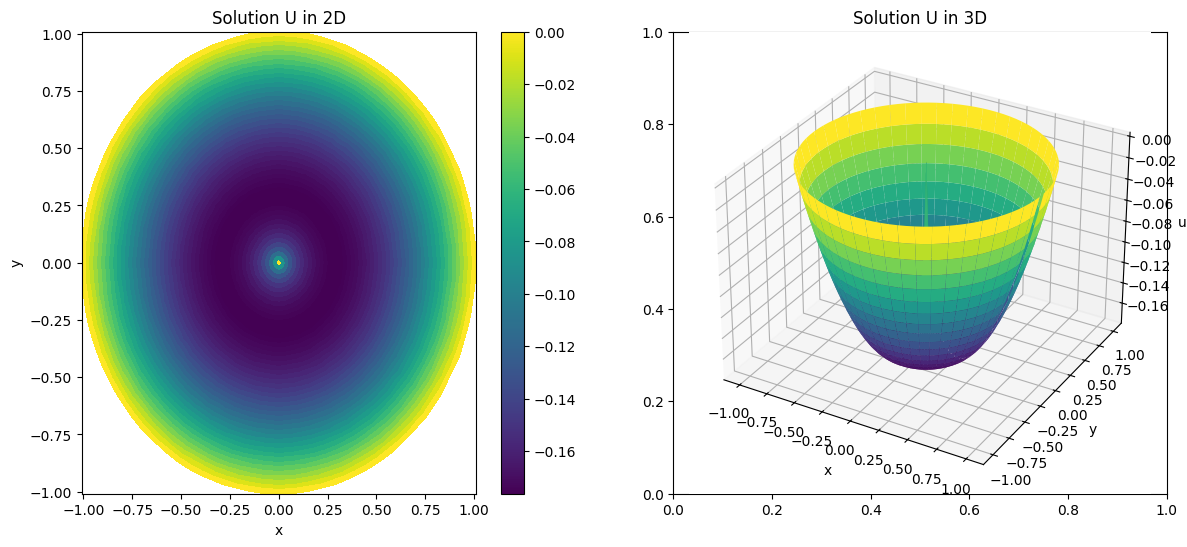

In [47]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def solve_poisson_unit_disc(f, Nr, Ntheta):
    # Create grid
    r = np.linspace(0, 1, Nr + 1)
    theta = np.linspace(0, 2 * np.pi, Ntheta, endpoint=False)
    dr = r[1] - r[0]
    dtheta = theta[1] - theta[0]
    
    # Initialize the solution vector and the right-hand side
    U = np.zeros((Nr + 1, Ntheta))
    F = np.zeros((Nr + 1, Ntheta))
    
    # Populate F with values of the function f on the grid
    for i in range(Nr + 1):
        for j in range(Ntheta):
            F[i, j] = f(r[i], theta[j])
    
    # Create sparse matrix for the linear system
    A = lil_matrix(((Nr + 1) * Ntheta, (Nr + 1) * Ntheta))
    b = np.zeros((Nr + 1) * Ntheta)
    
    # Fill the matrix and right-hand side
    for i in range(1, Nr):
        for j in range(Ntheta):
            k = i * Ntheta + j
            
            A[k, k] = -2 / dr**2 - 2 / (r[i]**2 * dtheta**2)
            A[k, k - 1 if j > 0 else k + Ntheta - 1] = 1 / (r[i]**2 * dtheta**2)
            A[k, k + 1 if j < Ntheta - 1 else k - Ntheta + 1] = 1 / (r[i]**2 * dtheta**2)
            A[k, k - Ntheta] = 1 / dr**2 - 1 / (2 * r[i] * dr)
            A[k, k + Ntheta] = 1 / dr**2 + 1 / (2 * r[i] * dr)
            
            b[k] = F[i, j]
    
    # Apply boundary conditions (u = 0 on the boundary)
    for j in range(Ntheta):
        k = j
        A[k, k] = 1
        b[k] = 0
        k = Nr * Ntheta + j
        A[k, k] = 1
        b[k] = 0
    
    # Solve the linear system
    A = A.tocsr()
    U_flat = spsolve(A, b)
    
    # Reshape the solution to 2D array
    U = U_flat.reshape((Nr + 1, Ntheta))
    
    return r, theta, U

# Example usage
def example_f(r, theta):
    #return np.sin(np.pi * r) * np.cos(theta)
    #return r*np.sin(theta) - r * np.cos(theta)
    return 1

Nr = 50
Ntheta = 100

r, theta, U = solve_poisson_unit_disc(example_f, Nr, Ntheta)

# Convert the polar grid to Cartesian coordinates for visualization
R, Theta = np.meshgrid(r, theta, indexing='ij')
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 2D plot
fig0 = axs[0].pcolormesh(X, Y, U, shading='auto')
fig.colorbar(fig0, ax=axs[0])
axs[0].set_title("Solution U in 2D")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# 3D plot
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_title("Solution U in 3D")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u")

plt.show()

In [146]:
X,Y = R*np.cos(Theta), R*np.sin(Theta)
model = FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu)

array([[1.00000000e-08, 3.22580742e-02, 6.45161384e-02, ...,
        9.35483872e-01, 9.67741936e-01, 1.00000000e+00],
       [9.79529939e-09, 3.15977495e-02, 6.31954891e-02, ...,
        9.16334460e-01, 9.47932200e-01, 9.79529939e-01],
       [9.18957808e-09, 2.96438091e-02, 5.92876091e-02, ...,
        8.59670208e-01, 8.89314008e-01, 9.18957808e-01],
       ...,
       [9.18957812e-09, 2.96438093e-02, 5.92876094e-02, ...,
        8.59670212e-01, 8.89314012e-01, 9.18957812e-01],
       [9.79529941e-09, 3.15977495e-02, 6.31954892e-02, ...,
        9.16334462e-01, 9.47932202e-01, 9.79529941e-01],
       [1.00000000e-08, 3.22580742e-02, 6.45161384e-02, ...,
        9.35483872e-01, 9.67741936e-01, 1.00000000e+00]])